# Создание и настройка рекурентной нейросети. Keras

Цель: научится имитировать поведение мышки юзера на любом веб-сайте

## Обработка данных

Данные для обучения модели используются с репозитория https://github.com/balabit/Mouse-Dynamics-Challenge

Кластеры разбиты на юзеров, которые посещали отслеживаемый сайт. Активность юзеров разбита на сеансы.

In [4]:
# формирование матриц данных из локальных файлов с сессиями пользователей

import os
import numpy as np
import pandas as pd
from IPython.display import display, HTML

DATA_DIR = os.getcwd() + '/data/test_files/'
users_sessions = os.listdir(DATA_DIR)
all_sessions = {i: os.listdir(DATA_DIR + i) for i in users_sessions}
print('Количество пользователей: %s' % len(all_sessions.keys()))
print('Общее количество сессий: %s' % sum([len(v) for v in all_sessions.values()]))


Количество пользователей: 10
Общее количество сессий: 1612


## Поля каждого файла сеанса:

- <b>record timestamp</b>: прошедшее время (в секундах) с начала сеанса, записанное устройством мониторинга netork
- <b>client timestamp</b>: прошедшее время (в секундах) с начала сеанса, записанное клиентом RDP
- <b>button</b>: текущее состояние кнопок мыши
- <b>state</b>: дополнительная информация о текущем состоянии мыши
- <b>x</b>: координата x курсора на экране
- <b>y</b>: координата y курсора на экране

In [5]:
# создание матрицы данных из всех сеансов одного юзера

def get_user_sessions(num_user):
    session = list(all_sessions.keys())[num_user]
    user_files = [DATA_DIR + session + '/' + i for i in all_sessions[session]]
    return user_files


def file_to_list(file):
    with open(file) as f:
        lt = f.readlines()
    return lt

def make_user_dataset(user_files):
    dataset = []
    columns = False
    for i in user_files:
        dataset += file_to_list(i)[1:]
        if not columns:
            columns = [i.replace(' ', '_').replace('\n', '').split(',')
                       for i in file_to_list(i)[0:1]][0]
    dataset = [i.replace('\n', '').split(',') for i in dataset]
    data = pd.DataFrame(dataset, columns=columns)
    return data

num_user = 0 # первый пользоваль в списке 
data = make_user_dataset(get_user_sessions(num_user))
print('Срез необработанной таблицы данных')
display(data[:30])
# HTML(data.head().to_html())

Срез необработанной таблицы данных


,record_timestamp,client_timestamp,button,state,x,y
0,0.0,0.0,NoButton,Move,630,474
1,0.108999967575,0.108999999939,Scroll,Down,0,0
2,0.110000133514,0.108999999939,NoButton,Move,631,508
3,0.218000173569,0.217999999993,Scroll,Down,0,0
4,0.218000173569,0.217999999993,NoButton,Move,629,539
5,0.344000101089,0.342999999993,Scroll,Down,0,0
6,0.344000101089,0.342999999993,NoButton,Move,628,549
7,0.764000177383,0.763999999966,Scroll,Down,0,0
8,0.764000177383,0.763999999966,NoButton,Move,627,551
9,0.764000177383,0.763999999966,Scroll,Down,0,0


## Препроцессинг. Нормализация, скаллинг, векторизация.

Оптимизируем данные для рекурентной нейросети:
- Конвертируем категориальные типы данных (колонки <b>button</b>, <b>state</b>) в one-hot матрицы;
- Нормализация колличественных типов данных к диапазону от 0 до 1. Используется объект скаллер
- Удаление лишней колонки <b>record_timestamp</b>

In [6]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import MinMaxScaler

# получение матрицы one-hot из категориальных данных
cols_to_retain = ['button', 'state']
pr_data = data[cols_to_retain].to_dict(orient='records_timestamp')
vec = DictVectorizer(sparse=False, dtype=float)
one_hot_data = vec.fit_transform(pr_data)

# скаляризация численных данных
cols_to_scal = ['client_timestamp', 'x', 'y']
scaler = MinMaxScaler(feature_range=(0, 1), copy=False)
data_scal = scaler.fit_transform(data[cols_to_scal])

category = vec.get_feature_names()
print('Перечень основных категорий\n')
print(category)
print('Категории после преобразования\n')
print(one_hot_data[:5])

Перечень основных категорий

['button=Left', 'button=NoButton', 'button=Right', 'button=Scroll', 'state=Down', 'state=Drag', 'state=Move', 'state=Pressed', 'state=Released', 'state=Up']
Категории после преобразования

[[ 0.  1.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  1.  0.  0.  0.]]


In [7]:
# формирование обработанной матрицы
pr_data = np.hstack((data_scal, one_hot_data)).astype(float)
print("Преобразованная таблица данных")
print(pr_data[:12])

Преобразованная таблица данных
[[  0.00000000e+00   9.61318379e-03   7.23277638e-03   0.00000000e+00
    1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  8.09974847e-06   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   1.00000000e+00   1.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  8.09974847e-06   9.62844282e-03   7.75158312e-03   0.00000000e+00
    1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  1.61994970e-05   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   1.00000000e+00   1.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  1.61994970e-05   9.59792477e-03   8.22461280e

### Векторизация.
Формирование векторов X и Y для обучения из временных последовательнотей.

Изменение формы входных данных на трёхмерный тензор. Длина шага - 20 (гиперпараметр в процессе подстройки). 

Разделение на тренировочный и тестовый набор данных. 

Для первой части обучения модели используем значения X и Y

In [8]:
STEP = 50
SPL = 0.7


def vectorizeXY(data, seq):
    X = np.zeros((data.shape[0], seq, data.shape[1]))
    Y = np.zeros((data.shape[0], data.shape[1]))
    for i in range(len(data) - seq - 1):
        X[i] = data[i:i + seq]
        Y[i] = data[i + seq + 1]
    return X, Y


def split_data(X, Y, spl):
    trainX = X[:int(len(X)*spl)]
    trainY = Y[:int(len(X)*spl)]
    testX = X[int(len(X)*spl):]
    testY = Y[int(len(X)*spl):]
    return trainX, testX, trainY, testY

In [9]:
# получаем значения перемещений, нормализируем
dataXY = data[['x', 'y']].values.astype('float')/1024
X, Y = vectorizeXY(dataXY, STEP)
trainX, testX, trainY, testY = split_data(X, Y, SPL)

print(trainX.shape, testX.shape, trainY.shape, testY.shape)

(166261, 50, 2) (71256, 50, 2) (166261, 2) (71256, 2)


# Создание модели рекурентной нейросети
Используется LSTM(долгая краткосрочная память) способная обучатся долгосрочным зависимостям.

Один скрытый слой, состоящий из 64 нейронов.

Длина батча 6000 (среднее значение одного сеанса)

Показатель качества верности - среднеквадратическая ошибка


In [10]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation
from keras.callbacks import ModelCheckpoint

model = Sequential()
model.add(LSTM(64, return_sequences=False, input_shape=(trainX.shape[1],
                                                        trainX.shape[2])))
model.add(Dense(trainY.shape[1], activation='relu'))
model.compile(loss='mse', optimizer='adam', metrics=["mean_squared_error"])

Using TensorFlow backend.


## Обучение модели. 20 эпох

In [12]:
history = model.fit(trainX, trainY, batch_size=6000,
                    epochs=20, verbose=2,
                    validation_data=(testX, testY), shuffle=False)

Train on 191849 samples, validate on 82221 samples
Epoch 1/20
 - 131s - loss: 0.5716 - mean_squared_error: 0.5716 - val_loss: 0.2029 - val_mean_squared_error: 0.2029
Epoch 2/20
 - 129s - loss: 0.4856 - mean_squared_error: 0.4856 - val_loss: 0.1832 - val_mean_squared_error: 0.1832
Epoch 3/20
 - 130s - loss: 0.4768 - mean_squared_error: 0.4768 - val_loss: 0.1789 - val_mean_squared_error: 0.1789
Epoch 4/20
 - 147s - loss: 0.4737 - mean_squared_error: 0.4737 - val_loss: 0.1764 - val_mean_squared_error: 0.1764
Epoch 5/20
 - 150s - loss: 0.4715 - mean_squared_error: 0.4715 - val_loss: 0.1745 - val_mean_squared_error: 0.1745
Epoch 6/20
 - 144s - loss: 0.4697 - mean_squared_error: 0.4697 - val_loss: 0.1728 - val_mean_squared_error: 0.1728
Epoch 7/20
 - 152s - loss: 0.4680 - mean_squared_error: 0.4680 - val_loss: 0.1714 - val_mean_squared_error: 0.1714
Epoch 8/20
 - 205s - loss: 0.4667 - mean_squared_error: 0.4667 - val_loss: 0.1702 - val_mean_squared_error: 0.1702
Epoch 9/20
 - 184s - loss: 0.

In [13]:
# оценка эффективности модели
import math
score, _ = model.evaluate(testX, testY, batch_size=6000)
rmse = math.sqrt(score)
print("\nMSE: {:.3f}, RMSE: {:.3f}".format(score, rmse))

82221/82221 [==============================] - 21s 254us/step

MSE: 0.162, RMSE: 0.403


In [11]:
model.save_weights(os.getcwd() + '/' + 'standartXY-1.hdf5')

# Визуализация полученных результатов

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

In [10]:
a = predict[:200, (0)]
b = testY[:200, (0)]
c = predict[:200, (1)]
d = testY[:200, (1)]

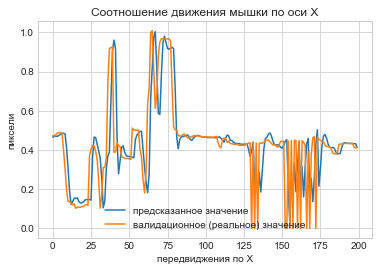

In [13]:
# визуализация соотношения предсказанных данных к валидационным
plt.plot(a, label='предсказанное значение')
plt.plot(b, label='валидационное (реальное) значение')
plt.title("Соотношение движения мышки по оси X")
plt.xlabel("передвиджения по X")
plt.ylabel("пиксели")
plt.legend()
plt.show()

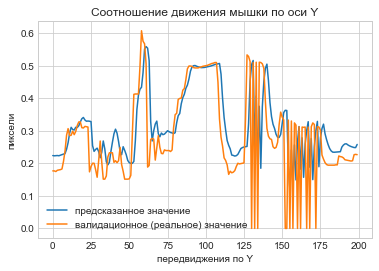

In [14]:
plt.plot(c, label='предсказанное значение')
plt.plot(d, label='валидационное (реальное) значение')
plt.title("Соотношение движения мышки по оси Y")
plt.xlabel("передвиджения по Y")
plt.ylabel("пиксели")
plt.legend()
plt.show()

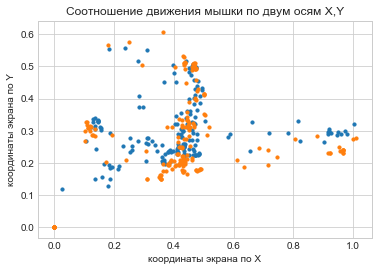

In [15]:
plt.scatter(a, c, s=10)
plt.scatter(b, d, s=10)
plt.title("Соотношение движения мышки по двум осям X,Y")
plt.xlabel("координаты экрана по X")
plt.ylabel("координаты экрана по Y")
plt.show()

На графиках видно, что нейросеть крайне отчетливо поняла все закономерности в перемещении мышки пользователя по екрану.

Успешность предсказаний почти 96%, что говорит о том, что модель обучена предсказывать поведение мышки.

Дальнейшие шаги обучения: добавить ещё один набор признаков - временная дельта между перемещением мышки по осям экрана.

## Декодирование и демонстрация работы нейросети

В папке с файлом блокнота прилагается видео.